In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import sklearn as sk
from sklearn import preprocessing as ppr

In [2]:
dataFrame = pd.read_csv('./international-airline-passengers.csv', usecols = [1], header = 0)[:-1]
dataset_orig = dataFrame.values.astype(np.float32)

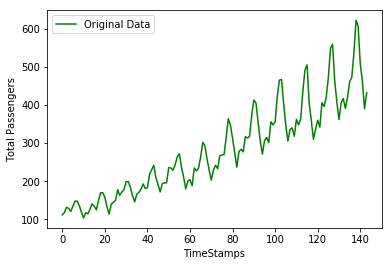

In [3]:
plt.plot(dataset_orig, label = "Original Data", c = 'g')
plt.legend()
plt.xlabel('TimeStamps')
plt.ylabel("Total Passengers")
plt.show()

In [4]:
# normalize the dataset
scaler = ppr.MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_orig)

In [5]:
def train_test_set(dataset, percentage_train = 0.75):
    l = len(dataset)
    train_set_end_index = int(l * 0.67)
    test_set_start_index = train_set_end_index + 1
    train_set = dataset[:test_set_start_index]
    test_set = dataset[test_set_start_index:]
    return train_set, test_set

def supervised_learning_form(train_dataset, test_dataset):
    train_x = train_dataset[:-1]
    train_y = train_dataset[1:]
    test_x = test_dataset[:-1]
    test_y = test_dataset[1:]
    return train_x, train_y, test_x, test_y

In [6]:
train_set, test_set = train_test_set(dataset)
train_x, train_y, test_x, test_y = supervised_learning_form(train_set, test_set)

In [218]:
# simple RNN in tensorflow

net_size = 20
n_epochs = 2000
n_x = 1
n_y = 1
n_timestamp = n_x
n_x_vars = 1
n_y_vars = 1
learning_rate = 0.08

In [232]:
tf.reset_default_graph()

In [233]:
# input and output placeholders
X_p = tf.placeholder(tf.float32, [None, n_timestamp, n_x_vars], name = "X_input")
Y_p = tf.placeholder(tf.float32, [None, n_timestamp, n_y_vars], name = "Y_output")

rnn_inputs = tf.unstack(X_p, axis = 1)

# setup the RNN
with tf.name_scope("RNN"):
    rnnCell = tf.nn.rnn_cell.LSTMCell(net_size, name = "rnn_cell")
    rnn_outputs, final_state = tf.nn.static_rnn(rnnCell, rnn_inputs, dtype=tf.float32)

    # weights and biases

    W = tf.get_variable('W', [net_size, n_y_vars])
    b = tf.get_variable('b', [n_y_vars], initializer=tf.constant_initializer(0.0))

In [234]:
# run predictions
predictions = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]

In [235]:
# unstack Y

y_as_list = tf.unstack(Y_p, num = n_timestamp, axis = 1)

In [236]:
# setup the backprop stuffs

losses = [tf.losses.mean_squared_error(labels = label, predictions = prediction) 
          for prediction, label in zip(predictions, y_as_list)]
total_loss = tf.reduce_mean(losses)
optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [237]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    epoch_loss = 0.0
    
    # tensorboard
    writer = tf.summary.FileWriter('./log', sess.graph)
    # training
    
    for epoch in range(n_epochs):
        
        # first loss, then predict, then run optimizer till n_epochs
        
        
        
        epoch_loss, y_train_prediction,_ = sess.run([total_loss, predictions, optimizer], 
                 feed_dict = { X_p : train_x.reshape(-1, n_timestamp, n_x_vars), 
                              Y_p : train_y.reshape(-1, n_timestamp, n_y_vars) })
        
        if epoch % 100 == 0:
            print("Loss after epoch " + str(epoch) + " : " + str(epoch_loss))
        
    print("Training mse :" + str(epoch_loss))
    
    #testing
    
    test_loss, y_test_prediction, _ = sess.run([total_loss, predictions, optimizer],
                  feed_dict = { X_p : test_x.reshape(-1, n_timestamp, n_x_vars), 
                                Y_p : test_y.reshape(-1, n_timestamp, n_y_vars) })
    print("Testing mse :" + str(test_loss))

Loss after epoch 0 : 0.07158862
Loss after epoch 100 : 0.0158956
Loss after epoch 200 : 0.0121930875
Loss after epoch 300 : 0.008921887
Loss after epoch 400 : 0.0062219943
Loss after epoch 500 : 0.004271889
Loss after epoch 600 : 0.0030698702
Loss after epoch 700 : 0.0024342835
Loss after epoch 800 : 0.0021388326
Loss after epoch 900 : 0.0020141948
Loss after epoch 1000 : 0.0019650215
Loss after epoch 1100 : 0.0019464273
Loss after epoch 1200 : 0.0019395523
Loss after epoch 1300 : 0.0019370153
Loss after epoch 1400 : 0.0019360498
Loss after epoch 1500 : 0.0019356472
Loss after epoch 1600 : 0.0019354444
Loss after epoch 1700 : 0.0019353124
Loss after epoch 1800 : 0.0019352059
Loss after epoch 1900 : 0.001935108
Training mse :0.0019350149
Testing mse :0.008867873


In [238]:
# "UN"-normalize the generated test and train dataset

y_train_prediction = scaler.inverse_transform(y_train_prediction[0])
y_test_prediction = scaler.inverse_transform(y_test_prediction[0])

In [239]:
# "UN"-normalize the real dataset

y_train_orig = scaler.inverse_transform(train_y)

In [240]:
# "UN"-normalize the test dataset

y_test_orig = scaler.inverse_transform(test_y)

In [241]:
y_test_prediction_shifted = np.empty_like(dataset_orig)
y_test_prediction_shifted[:len(y_train_orig) + 1] = np.nan
y_test_prediction_shifted[len(y_train_orig) + 1:-1] = y_test_prediction
y_test_prediction_shifted[-1] = np.nan

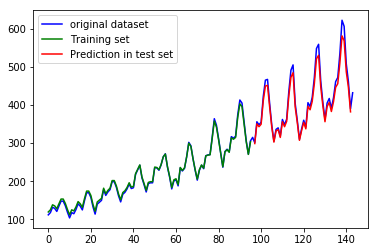

In [242]:
plt.plot(dataset_orig, label = "original dataset", c = 'b')
plt.plot(y_train_prediction, label = "Training set", c = 'g')
plt.plot(y_test_prediction_shifted, label = "Prediction in test set", c = 'r')
plt.legend()
plt.show()